In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np
from bisect import bisect_left
from scipy import optimize
from numpy import asarray
from math import *

from scipy.optimize import fmin

%matplotlib inline 

doAddReverse = True

In [2]:
# First input: FLUKA simulation of radiation levels in a curved sector of the Large Hadron Collider (LHC)
# Radiation source: interaction of the proton beam with residual gas elements in the beam pipe
# The LHC arc consists in a regular sequence of 53.45m long half-cells, all with the same structure
# The simulation includes three subsequent half-cells (18,19,20) 
# The radiation levels are best modelled in half-cell 20
# The input files include the radiation level 'scoring' below the different magnets within each half-cell

halfcellmin = 0.
halfcellmax = 5345. #5345.
filenum = ["1903","","01","02","03"]
quantity = ["TID","HEH","ThNeutrons","1MeVneq"]
inputname = dict()
inputname["TID"] = "DoseMB" # radiation-related quantity: Total Ionising Dose
inputname["HEH"] = "HEHADEQ" # radiation-related quantity: High Energy Hadron fluence
inputname["ThNeutrons"] = "THNEUT" # radiation-related quantity: thermal neutron fluence
inputname["1MeVneq"] = "Si1MeV" # radiation-related quantity: 1MeV neutron equivalent fluence
xmin=dict()
xmax=dict()
dose=dict()
fluence=dict()
radiation_all=dict()
radiation_cut=dict()
filename=dict()
mylabel=dict()

mylabel["1903"]="Q" # FLUKA results under quadrupole magnet in half-cell 19
mylabel[""]="BA" # FLUKA results under first dipole magnet in half-cell 20
mylabel["01"]="BB" # FLUKA results under second dipole magnet in half-cell 20
mylabel["02"]="BC" # FLUKA results under third dipole magnet in half-cell 20
mylabel["03"]="Q" # FLUKA results under quadrupole magnet in half-cell 20

# FLUKA normalization parameters
deltas = 1.27e+04
sigma = 3.84e-26
fp = 2.00e+08
ff = 1.12e+04

fdoseHEH = dict()
fdoseHEH["TID"] = 1.60e-07
fdoseHEH["HEH"] = 1.
fdoseHEH["ThNeutrons"] = 1.
fdoseHEH["1MeVneq"] = 1.
extrafactor=2.
if doAddReverse==True :
    extrafactor=1.

for f in filenum :
    xmin[f] = dict()
    xmax[f] = dict()
    radiation_all[f] = dict()
    radiation_cut[f] = dict()
    filename[f] = dict()
    for q in quantity :
        xmin[f][q] = []
        xmax[f][q] = []
        radiation_all[f][q] = []
        radiation_cut[f][q] = []
        filename[f][q] = inputname[q]+f+".dat"
        print ('Working on' , filename[f][q])
        infile = open(filename[f][q],'r')
        for line in infile :
            myl = line.replace('\n','')
            if '#' in myl :
                continue
            if len(myl.strip())==0 :
                break
            l = myl.split(' ')
            #print (myl)
            #print (halfcell , int(l[1]))
            xmin[f][q].append(int(l[0]))
            xmax[f][q].append(int(l[1]))
            radiation_all[f][q].append(float(l[2])*deltas*sigma*fp*ff*fdoseHEH[q]*extrafactor)
        #print ('X min: ' , xmin[f])
        #print ('X max: ' , xmax[f])
        #print ('Radiation: ' , radiation[f])


Working on DoseMB1903.dat
Working on HEHADEQ1903.dat
Working on THNEUT1903.dat
Working on Si1MeV1903.dat
Working on DoseMB.dat
Working on HEHADEQ.dat
Working on THNEUT.dat
Working on Si1MeV.dat
Working on DoseMB01.dat
Working on HEHADEQ01.dat
Working on THNEUT01.dat
Working on Si1MeV01.dat
Working on DoseMB02.dat
Working on HEHADEQ02.dat
Working on THNEUT02.dat
Working on Si1MeV02.dat
Working on DoseMB03.dat
Working on HEHADEQ03.dat
Working on THNEUT03.dat
Working on Si1MeV03.dat


In [3]:
# offset quantities to correctly set the position of each magnet within half-cell 20

offset=dict()
offset["1903"] = 0 
offset[""] = 280 + 830 
offset["01"] = 280 + (830*3)-90 
offset["02"] = 280 + (830*5)-175 
offset["03"] = 280 + (830*6)+100 

xprime=dict()


#create dictionaries with radiation levels in the relevant positions within half-cell 20 (including the position offsets above)
for f in filenum :
    xprime[f]=dict()
    for q in quantity :
        xprime[f][q]=[]
        for i in range(0,len(xmin[f][q])) :
            m_xmin = xmin[f][q][i] + offset[f]
            m_xmax = xmax[f][q][i] + offset[f]
            if ((float(m_xmin+m_xmax)/2) < (halfcellmax)) and ((float(m_xmin+m_xmax)/2) > (halfcellmin)) :
                xprime[f][q].append(float(m_xmin+m_xmax)/2) 
                radiation_cut[f][q].append(radiation_all[f][q][i])
        #print ('Working on' , filename[f][q])
        #print ('X prime: ' , xprime[f][q])
        


In [4]:
# position of single radiation monitors (Beam Loss Monitors, BLM) and corresponding TID levels in FLUKA and in annual (2016) LHC data

BLMdata_b1b2_x = [206,456,1890,3456,4901,5210]
BLMdata_b1b2_doseFluka = [1.49e-21,4.41e-22,1.03e-21,1.03e-21,4.41e-22,1.49e-21] # b1+b2, normalised to integrated intensity
BLMdata_b1b2_dose2016 = [65.3,33.2,63.0,65.5,40.5,84.1] # BLM data (no norm) 

magnets_xmin = [-160,380,1940,3500,5185] #impose that the first MB begins at x=1m
magnets_xmax = [160,1840,3400,4960,5505]
magnets_label = ["MQ","MBA","MBB","MBC","MQ"]
magnets_label_x = [-100,1000+3,2500+3,4150+3,5250]

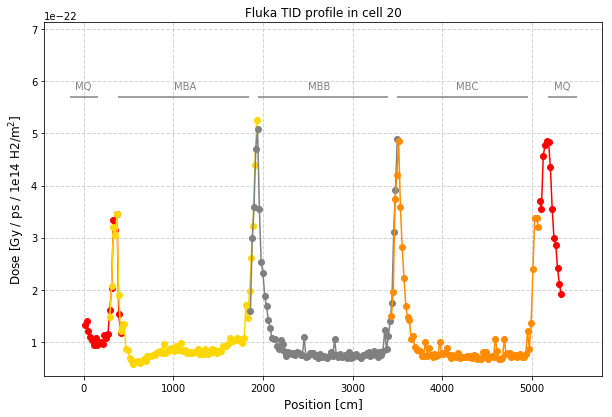

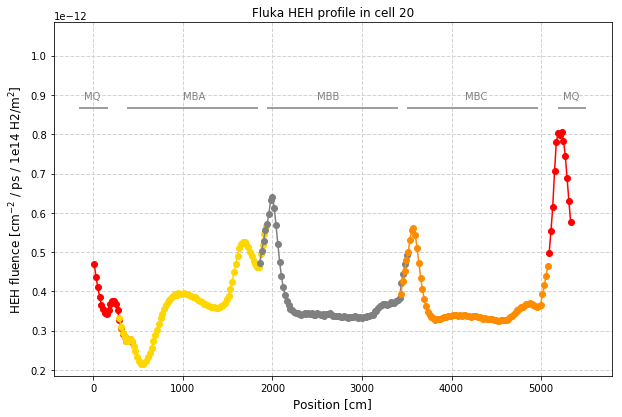

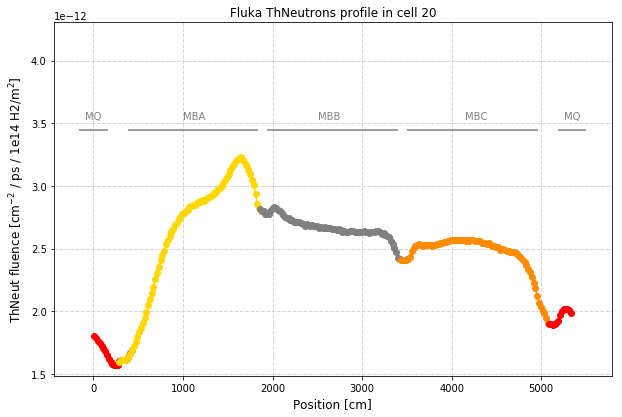

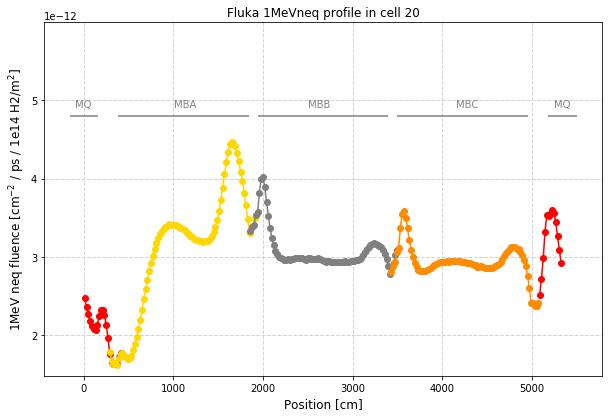

In [5]:
# plot TID, HEH fluence, thermal neutron fluence and 1MeV neutron equivalent fluence in half-cell 20
# only FLUKA results are shown
# so far the simulation considers only radiation produced by one beam
# (note: the LHC accelerator has two beams circulating in clockwise and anti-clockwise directions)

mycolor=dict()
mycolor["1903"] = 'red'
mycolor[""] = 'gold'
mycolor["01"] = 'gray'
mycolor["02"] = 'darkorange'
mycolor["03"] = 'red'

yax=dict()
yax["TID"] = "Dose [Gy "
yax["HEH"] = "HEH fluence [cm$^{-2}$ "
yax["ThNeutrons"] = "ThNeut fluence [cm$^{-2}$ "
yax["1MeVneq"] = "1MeV neq fluence [cm$^{-2}$ "

fig = dict()
ax = dict()

for q in quantity :
    fig[q] = plt.figure(facecolor = 'white',figsize=(10,6.5))
    ax[q] = fig[q].add_subplot(1,1,1)
    #ax2 = ax.twinx()
    ax[q].set_title('Fluka '+q+' profile in cell 20')
    for f in filenum :
        ax[q].plot(xprime[f][q],radiation_cut[f][q],color=mycolor[f],label='M'+mylabel[f],marker='o')


    ax[q].set_ylabel(yax[q]+'/ ps / 1e14 H2/m$^2$]',fontsize = 12)        
    ax[q].set_xlabel('Position [cm]', fontsize = 12)
    ax[q].set_ylim(top=ax[q].get_ylim()[1]*1.3)
    
    ax[q].grid(color='lightgray', linestyle='--', linewidth=1,axis='x')
    ax[q].grid(color='lightgray', linestyle='--', linewidth=1,axis='y')
    
    
    for i in range(0,len(magnets_label)) :
        ax[q].hlines(y=0.8*float(ax[q].get_ylim()[1]), xmin=magnets_xmin[i], xmax=magnets_xmax[i],color='gray')
        plt.text(magnets_label_x[i],0.82*float(ax[q].get_ylim()[1]),magnets_label[i],color='gray')



In [6]:
# symmetrize FLUKA radiation profiles to represent the contribution from both beams 
# (note: the radiation levels produced by each beam are symmetric with respect to the centre of each half-cell)

xprime_full = dict()
radiation_full = dict()

for q in quantity :
    xprime_full[q] = []
    radiation_full[q] = []
    for f in filenum :
        for i in range(0,len(xprime[f][q])) :
            if (len(xprime_full[q])==0 or xprime[f][q][i] > xprime_full[q][len(xprime_full[q])-1]):
                #if len(xprime_full[q])>0 :
                #    print ('Debug: ' , xprime[f][q][i] , xprime_full[q][len(xprime_full)-1] , xprime_full[q])
                xprime_full[q].append(xprime[f][q][i])
                radiation_full[q].append(radiation_cut[f][q][i])
    #print ('Xprime full ' , q , ' with length' , len(xprime_full[q]) , ': ' , xprime_full[q])
    #print ('Radiation full ' , q , ' with length' , len(radiation_full[q]) , ': ' , radiation_full[q])

radiation_sym = dict()

def takeClosest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.
    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
       return after
    else:
       return before

for q in quantity :
    radiation_sym[q] = []
    for i in range(0,len(xprime_full[q])) :
        symmetric_x = halfcellmax - xprime_full[q][i]
        if symmetric_x in xprime_full[q] : # symmetric element "exactly" found
            i_sym = xprime_full[q].index(symmetric_x)
            radiation_sym[q].append(radiation_full[q][i]+radiation_full[q][i_sym])
            #print ('Test: ' , xprime_full[q][i] , symmetric_x , xprime_full[q][i_sym])
        else : # look for closest x position
            closest = takeClosest(xprime_full[q], symmetric_x)
            i_sym = xprime_full[q].index(closest)
            radiation_sym[q].append(radiation_full[q][i]+radiation_full[q][i_sym])
            #print ('Test: ' , xprime_full[q][i] , symmetric_x ,  closest , xprime_full[q][i_sym])

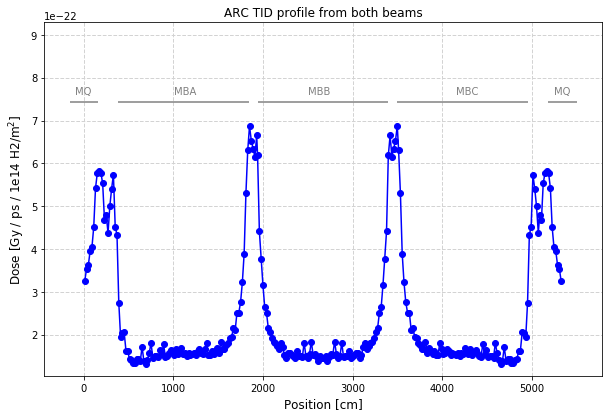

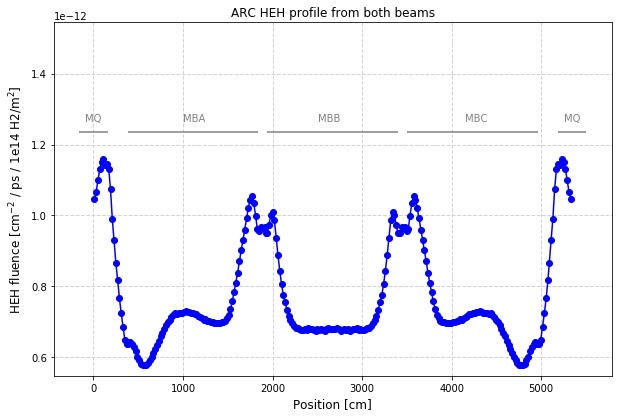

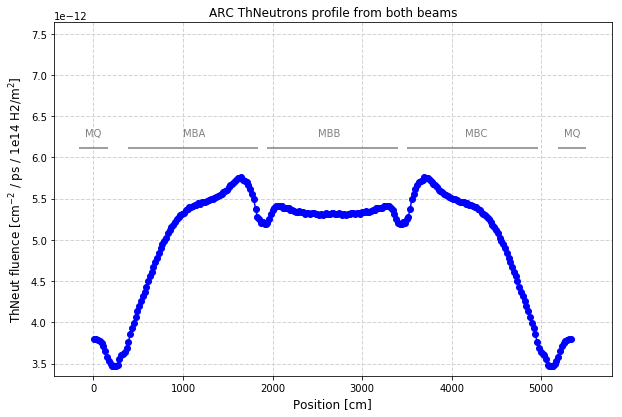

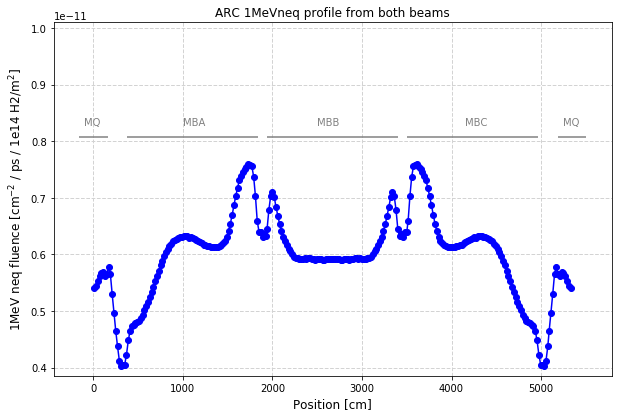

In [7]:
# plot FLUKA radiation profiles symmetrized with respect to the centre of each half-cell

fig2 = dict()
ax2 = dict()

for q in quantity :
    fig2[q] = plt.figure(facecolor = 'white',figsize=(10,6.5))
    ax2[q] = fig2[q].add_subplot(1,1,1)
    #ax2 = ax.twinx()
    ax2[q].set_title('ARC '+q+' profile from both beams')

    ax2[q].plot(xprime_full[q],radiation_sym[q],color='blue',label='Symmetrised radiation profile',marker='o')

    #if q=="TID" :
    #    ax[q].plot(BLMdata_b1b2_x,BLMdata_b1b2_dose,color='black',label='BLM data',marker='o')

    ax2[q].set_ylabel(yax[q]+'/ ps / 1e14 H2/m$^2$]',fontsize = 12)        
    ax2[q].set_xlabel('Position [cm]', fontsize = 12)
    ax2[q].set_ylim(top=ax2[q].get_ylim()[1]*1.3)
    
    #ax[q].legend(loc=(0.66, 0.85), prop = {'size':12}, numpoints = 1, ncol=2)

    #plt.xticks(np.arange(0.,7000., step=1000))
    ax2[q].grid(color='lightgray', linestyle='--', linewidth=1,axis='x')
    ax2[q].grid(color='lightgray', linestyle='--', linewidth=1,axis='y')
    
    
    for i in range(0,len(magnets_label)) :
        ax2[q].hlines(y=0.8*float(ax2[q].get_ylim()[1]), xmin=magnets_xmin[i], xmax=magnets_xmax[i],color='gray')
        plt.text(magnets_label_x[i],0.82*float(ax2[q].get_ylim()[1]),magnets_label[i],color='gray')




In [8]:
# prepare to plot ratios of different radiation quantities (HEH/TID, 1MeVneq/TID, thermal/HEH)

ratios = ["HEHtoTID","1MeVneqtoTID","ThNeutronstoHEH"] # each element contains num,den
radiation_ratios = dict()

#for f in filenum :
#    radiation_ratios[f] = dict()
for rat in ratios :
    radiation_ratios[rat] = []
    pos = rat.find('to')
    #print (pos , rat[pos+2:])
    num = rat[0:pos]
    den = rat[pos+2:]
    for i in range(0,len(radiation_sym[num])) :
        radiation_ratios[rat].append(radiation_sym[num][i]/radiation_sym[den][i])

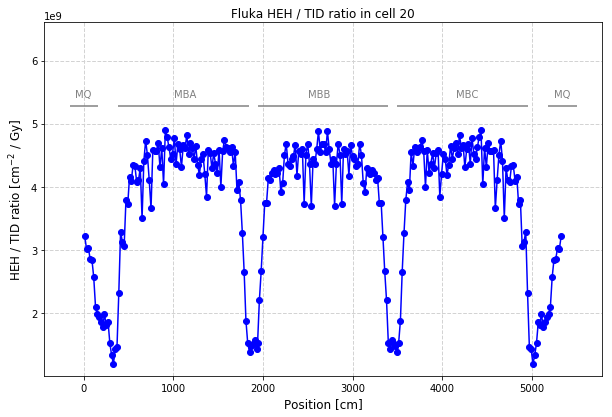

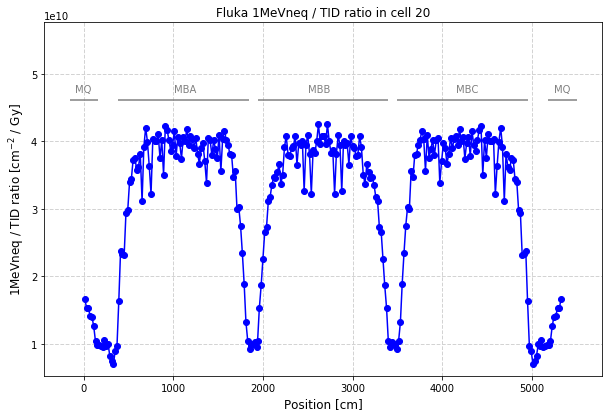

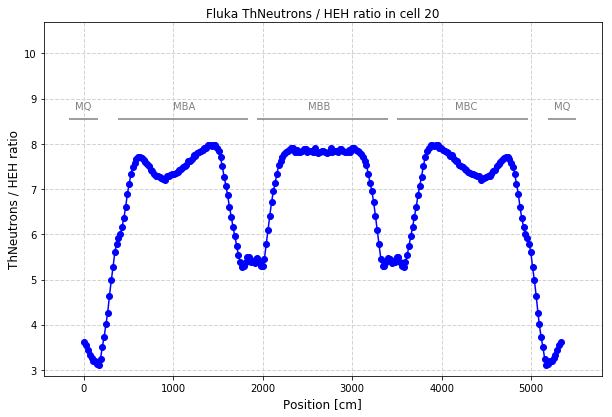

In [9]:
# plot ratios quantities

figratio = dict()
axratio = dict()

for rat in ratios :
    
    pos = rat.find('to')
    #print (pos , rat[pos+2:])
    num = rat[0:pos]
    den = rat[pos+2:]
    
    figratio[rat] = plt.figure(facecolor = 'white',figsize=(10,6.5))
    axratio[rat] = figratio[rat].add_subplot(1,1,1)
    axratio[rat].set_title('Fluka '+num+' / '+den+' ratio in cell 20')
    #for f in filenum :
    axratio[rat].plot(xprime_full[num],radiation_ratios[rat],color='blue',label='Ratio of symmetrised radiation profiles',marker='o')

    extralabel = ""
    if den=="TID" :
        extralabel = " [cm$^{-2}$ / Gy]"
    axratio[rat].set_ylabel(num+' / '+den+' ratio'+extralabel,fontsize = 12)        
    axratio[rat].set_xlabel('Position [cm]', fontsize = 12)
    axratio[rat].set_ylim(top=axratio[rat].get_ylim()[1]*1.3)
    
    axratio[rat].grid(color='lightgray', linestyle='--', linewidth=1,axis='x')
    axratio[rat].grid(color='lightgray', linestyle='--', linewidth=1,axis='y')
    
    for i in range(0,len(magnets_label)) :
        axratio[rat].hlines(y=0.8*float(axratio[rat].get_ylim()[1]), xmin=magnets_xmin[i], xmax=magnets_xmax[i],color='gray')
        plt.text(magnets_label_x[i],0.82*float(axratio[rat].get_ylim()[1]),magnets_label[i],color='gray')




Optimization terminated successfully.
         Current function value: 0.389442
         Iterations: 21
         Function evaluations: 42
Best-fitted 2016 vacuum pressure (from FLUKA-data fit):  4.43e+12


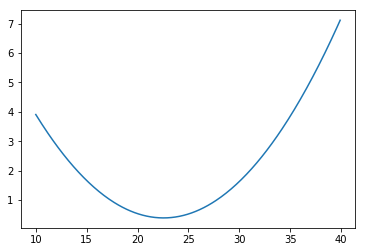

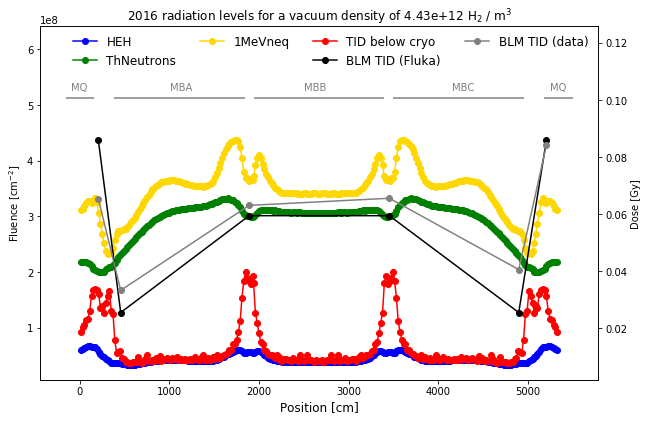

In [10]:
intensity2016 = 1.3e21 # time-integrated beam intensity in 2016 for each LHC beam

mycolor2=dict()
mycolor2["TID"] = 'red'
mycolor2["HEH"] = 'blue'
mycolor2["ThNeutrons"] = 'green'
mycolor2["1MeVneq"] = 'gold'

mylabel=dict()
mylabel["TID"] = 'TID'
mylabel["HEH"] = 'HEH fluence'
mylabel["ThNeutrons"] = 'ThNeut fluence'
mylabel["1MeVneq"] = '1MeV neq fluence'

# fit FLUKA BLM prediction to 2016 BLM data to derive the normalisation of the FLUKA simulation for the annual 2016 levels
def quad(x,a,b):
    if len(a)!=len(b):
        print ("ERROR! Wrong lengths")
        return -1
    q=0
    for i in range(0,len(a)) :
        q += (x*a[i]-b[i])**2
    return q

x = np.arange(10, 40, 0.1)

def myq(x) :
    return quad(x,[0.001*x for x in BLMdata_b1b2_dose2016],[intensity2016*x for x in BLMdata_b1b2_doseFluka])
minimum = fmin(myq,10)[0]
#plt.plot(x,quad(x,[0.001*x for x in BLMdata_b1b2_dose2016],[intensity2016*x for x in BLMdata_b1b2_doseFluka]))
plt.plot(x,myq(x))
scalefactor=1/minimum

print ('Best-fitted 2016 vacuum pressure (from FLUKA-data fit): ' , str('{:0.2e}'.format(1e14*scalefactor)))
# expect to obtain = 4.3e12 # H2 / m3 

# make single FLUKA and BLM data plot for total 2016 intensity
fig2016 = plt.figure(facecolor = 'white',figsize=(10,6.5))
ax2016 = fig2016.add_subplot(1,1,1)
ax2016bis = ax2016.twinx()

for q in quantity :
    
    if q=="TID" :
        continue
    
    ax2016.plot(xprime_full[q],[scalefactor*intensity2016*x for x in radiation_sym[q]],color=mycolor2[q],label=q,marker='o')

ax2016.set_ylabel('Fluence [cm$^{-2}$]')        
ax2016.set_xlabel('Position [cm]', fontsize = 12)
#ax2016.set_yscale('log')
ax2016.set_ylim(ax2016.get_ylim()[0]/2,ax2016.get_ylim()[1]*1.4)

ax2016bis.plot(xprime_full["TID"],[scalefactor*intensity2016*x for x in radiation_sym["TID"]],color=mycolor2["TID"],label='TID below cryo',marker='o')
ax2016bis.plot(BLMdata_b1b2_x,[scalefactor*intensity2016*x for x in BLMdata_b1b2_doseFluka],color='black',label='BLM TID (Fluka)',marker='o')
ax2016bis.plot(BLMdata_b1b2_x,[0.001*x for x in BLMdata_b1b2_dose2016],color='gray',label='BLM TID (data)',marker='o')


ax2016bis.set_ylabel('Dose [Gy]')        
ax2016bis.set_xlabel('Position [cm]', fontsize = 12)
#ax2016bis.set_yscale('log')
ax2016bis.set_title('2016 radiation levels for a vacuum density of '+str('{:0.2e}'.format(1e14*scalefactor))+' H$_2$ / m$^3$')
ax2016bis.set_ylim(ax2016bis.get_ylim()[0]/2,ax2016bis.get_ylim()[1]*1.4)

ax2016.legend(loc=(0.05, 0.87), prop = {'size':12}, numpoints = 1, ncol=2, frameon=False)

ax2016bis.legend(loc=(0.48, 0.87), prop = {'size':12}, numpoints = 1, ncol=2, frameon=False)

for i in range(0,len(magnets_label)) :
    ax2016.hlines(y=0.8*float(ax2016.get_ylim()[1]), xmin=magnets_xmin[i], xmax=magnets_xmax[i],color='gray')
    ax2016.text(magnets_label_x[i],0.82*float(ax2016.get_ylim()[1]),magnets_label[i],color='gray')




    
